# Continuous-time multivariate deterministic model: Predator-prey model
## Yoav Ram

In [1]:
from functools import partial

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
sns.set_palette('muted')

import scipy
from scipy.integrate import solve_bvp, solve_ivp, odeint
from ipywidgets import interact # not a must, but can install with conda install -c conda-forge ipywidgets

The [Lotka-Volterra model](https://en.wikipedia.org/wiki/Lotka–Volterra_equations) is a model of species interactions, which can consist of competition, cooperation, or other types of interactions. 
It is commonly reffered to as a _predator-prey_ model, which is what we will focus on today.

# Predator-prey model

![lynx and hare](http://1.bp.blogspot.com/-ukeoZMEmIkM/VP7psdQO-vI/AAAAAAAACkE/9Togukgl4Yk/s1600/bobby.jpg)
![lion and gnu](http://www.differencebetween.info/sites/default/files/images/5/prdators.jpg)
![owl and mouse](https://i.ytimg.com/vi/7s0mpZ18Zaw/hqdefault.jpg)


The predator-prey model is summarized by these ordinary differential equations (ODE):

$$
\frac{dx}{dt} = b x - h x y \\
\frac{dy}{dt} = \epsilon h x y - d y
$$

where the parameters are:
- $x$ is the density of the *prey* (hare, gnu, mouse)
- $y$ is the density of the *predator* (lynx, lion, owl)
- $b$ is the *prey* birth rate
- $d$ is the *predator* death rate
- $h$ is the rate at which, when *predator* and *prey* meet, predation occurs
- $\epsilon$ is the rate at which *prey* density is converted to *predator* density when predation occurs

# Dynamics

To implement the model we first write the ODE as a function:

In [122]:
def dxydt(t, xy, b, h, ϵ, d):
    x, y = xy
    dx = b * x - h * x * y
    dy = ϵ * h * x * y - d * y
    return np.array([dx, dy])

## Integration

Now let's integrate the ODE.


### Hand-made integration

First let's implement an integration method of our own by making a discrete linear approximation of the ODE:

$$
x_{t} = x_{t-1} + \frac{d x}{d t} \cdot dt \\
y_{t} = y_{t-1} + \frac{d y}{d t} \cdot dt
$$

This is considered the simplest first-order integration method, called the [Euler method](https://en.wikipedia.org/wiki/Euler_method).

In [123]:
# model parameters
b = 1
h = 0.005
ϵ = 0.8
d = 0.6

steps = 100000 # number integration steps
xy = np.empty((2, steps)) # population array
xy[:,0] = 50, 100 # initial population sizes
dt = 0.001 # time step for integration

for t in range(1, steps):
    xy[:, t] = xy[:, t-1] + dxydt(t, xy[:, t-1], b, h, ϵ, d) * dt

x = xy[0, :]
y = xy[1, :]
t = np.arange(0, dt * steps, dt)

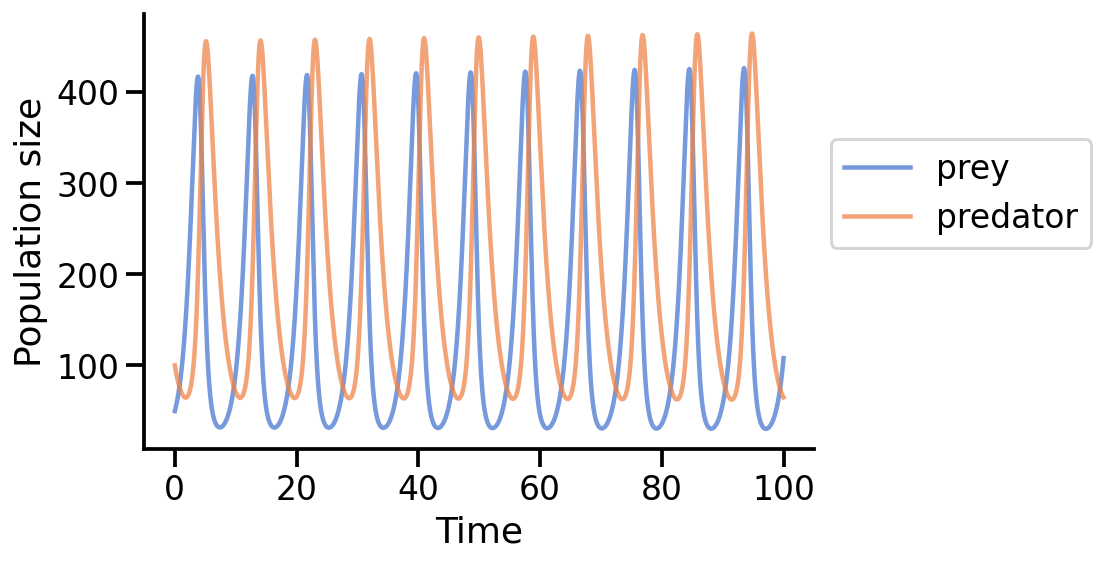

In [124]:
plt.plot(t, x, alpha=0.75, label='prey')
plt.plot(t, y, alpha=0.75, label='predator')

plt.xlabel('Time')
plt.ylabel('Population size')
# bbox_to_anchor places the legend at specific position, in this case outside the plot
plt.legend(bbox_to_anchor=(1, 0.75))
sns.despine()

We can see the cycles: more prey = more food for predators = more predators = less prey = less food for predators = less predators = more prey ...

Another way to visualize the dynamics as *orbits* in phase space.

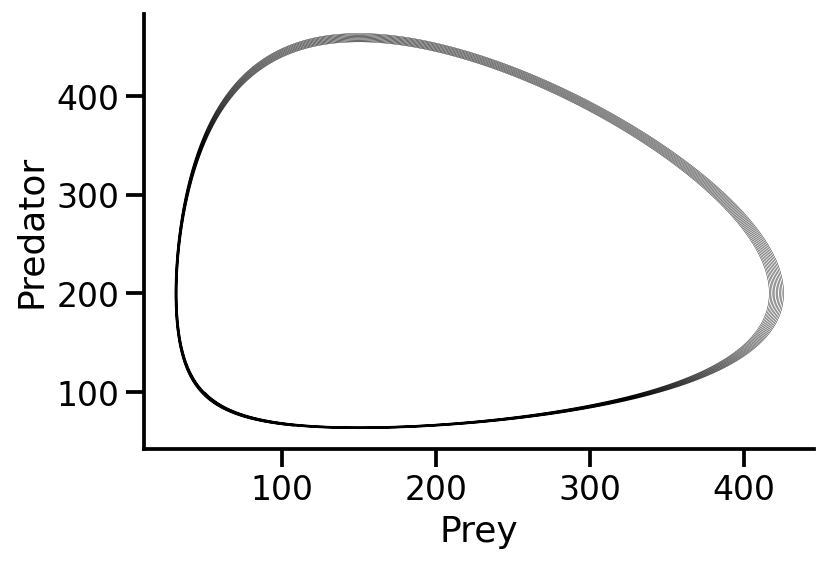

In [125]:
plt.plot(x, y, linewidth=0.2, color='k')
plt.xlabel('Prey')
plt.ylabel('Predator')
sns.despine()

### Integration with SciPy

We are better off using one of SciPy's [`solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) function, which automatically choses `dt` and `steps` to make sure `dx` and `dy` are small so that the linearization is effective.

Note: `solve_inp` is relatievely new, the previous solver (which you can still use) is called `odeint`.

Some of the solvers require the Jacobian, or the matrix of 2nd order parital derivatives:

$$
\mathbf{J}(x, y) = 
\pmatrix{
    \frac{\partial^2 x}{\partial t \partial x} & \frac{\partial^2 x}{\partial t \partial y} \\
    \frac{\partial^2 y}{\partial t \partial x} & \frac{\partial^2 y}{\partial t \partial y}
} = 
\pmatrix{
    b - h y & -h x \\
    \epsilon h y & \epsilon h x - d
}
$$

In [126]:
def jac(t, xy, b, h, ϵ, d):
    x, y = xy
    return np.array([
        [b - h * y, -h * x],
        [ϵ * h * y, ϵ * h * x - d]
    ])

We make a partial version of the `dxydt` and of `jac` which has the model parameters fixed, and use `solve_ivp` with the BDF solver (_backward differentiation formula_).

We plot the dynamics plots.
We also add quivers to the phase plot to anotate the direction of the dynamics.

In [127]:
t = np.linspace(0, 50, 50*10)
xy0 = (50, 100)
dxydt_ = partial(dxydt, b=b, h=h, ϵ=ϵ, d=d)
jac_ = partial(jac, b=b, h=h, ϵ=ϵ, d=d)
sol = solve_ivp(dxydt_, (t.min(), t.max()), xy0, t_eval=t, method='BDF', jac=jac_)

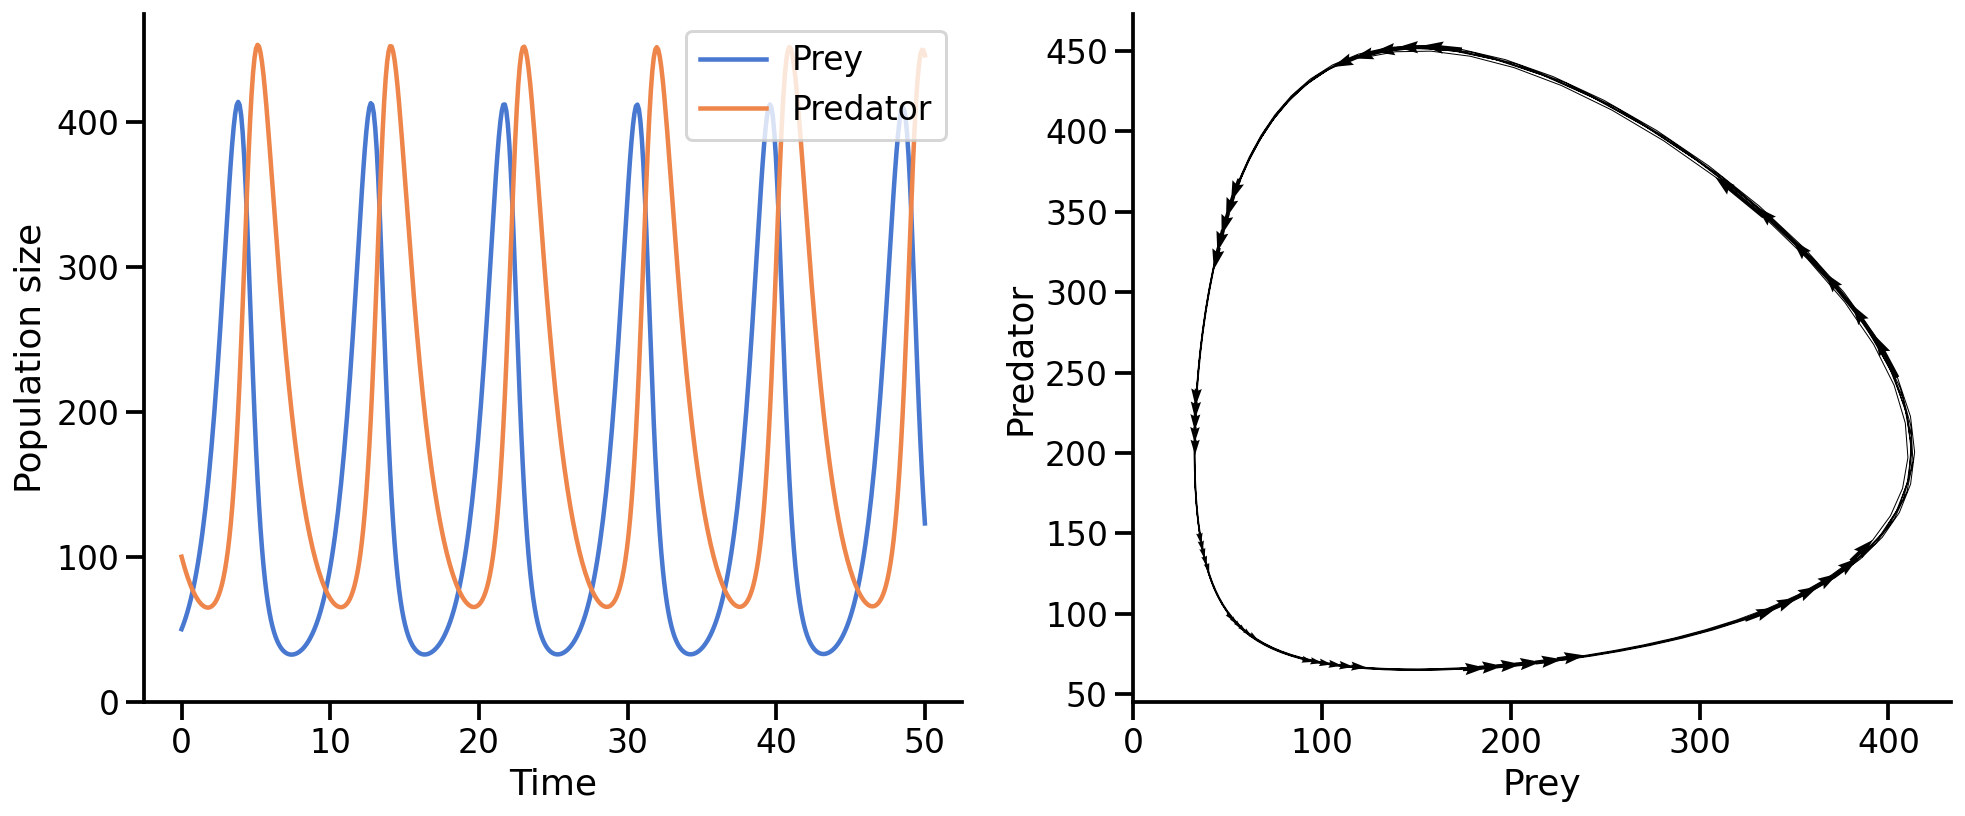

In [128]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
q_dt = 10

axes[0].plot(sol.t, sol.y.T)
axes[1].plot(sol.y[0,:], sol.y[1,:], lw=0.5, color='k')
axes[1].quiver(sol.y[0,:-1:q_dt], sol.y[1,:-1:q_dt], 
               sol.y[0,1::q_dt]-sol.y[0,:-1:q_dt], 
               sol.y[1,1::q_dt]-sol.y[1,:-1:q_dt], 
               scale_units='xy', angles='xy', scale=1, width=0.005)

axes[0].set(xlabel='Time', ylabel='Population size', ylim=(0, None))
axes[1].set(xlabel='Prey', ylabel='Predator', xlim=(0, None))
axes[0].legend(['Prey', 'Predator'], loc=1)

fig.tight_layout()
sns.despine()

**Note** this is an example where the `method` of the ODE solver is important - change the method and you don't get a cycle due to numerical errors.

The plots look similar, except that maybe the phase plot is more tight. 
We immediately see that we have a cycle, which seems stable!

Let's wrap this in a function that also plots the dynamics so that we can easily reuse it later.

In [129]:
def solve_plot(x0, y0, tmax, b, h, ϵ, d, q_dt=10, return_value=True):
    t = np.linspace(0, tmax, tmax*10)
    xy0 = (x0, y0)
    dxydt_ = partial(dxydt, b=b, h=h, ϵ=ϵ, d=d)
    jac_ = partial(jac, b=b, h=h, ϵ=ϵ, d=d)
    sol = solve_ivp(dxydt_, (t.min(), t.max()), xy0, t_eval=t, method='BDF', jac=jac_)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].plot(sol.t, sol.y.T)
    axes[1].plot(sol.y[0,:], sol.y[1,:], lw=0.5, color='k')
    axes[1].quiver(sol.y[0,:-1:q_dt], sol.y[1,:-1:q_dt], 
                   sol.y[0,1::q_dt]-sol.y[0,:-1:q_dt], 
                   sol.y[1,1::q_dt]-sol.y[1,:-1:q_dt], 
                   scale_units='xy', angles='xy', scale=1, width=0.005)

    axes[0].set(xlabel='Time', ylabel='Population size', ylim=(0, None))
    axes[1].set(xlabel='Prey', ylabel='Predator')
    axes[0].legend(['Prey', 'Predator'])
    fig.tight_layout()
    sns.despine()
    if return_value: return sol.t, sol.y

We can explore the dynamics for different values using `interact` - try to check if the cycle is stable for other choice of parameters.

In [130]:
interact(solve_plot,
        x0=(1, 100, 1), y0=(1, 100, 1), tmax=(1, 1001, 10), 
        b=(0, 2, 0.1), h=(0, 0.1, 0.001), ϵ=(0, 1, 0.01), d=(0, 2, 0.1));

interactive(children=(IntSlider(value=50, description='x0', min=1), IntSlider(value=50, description='y0', min=…

# Equilibrium

Equilibriums, i.e. steady states, fixed points, or stable states, are a very important concept in dynamic models.

Population equilibrium occurs in the model when neither of the populations change, that is, when both of the derivatives are equal to 0:

$$
bx - hxy = 0 \\
\epsilon h x y - d y = 0 \Rightarrow \\
x (b - hy) = 0 \\
y (\epsilon h x - d) = 0
$$

The trivial solutions have $x=0$ and/or $y=0$.
Assuming both are positive,

$$
x^* = \frac{d}{\epsilon h} \\
y^* = \frac{b}{h}
$$

- Equilibrium predator density $y^*$ is defined by the ratio of prey birth rate and predation rate.
- Equilibrium prey density $x^*$ is defined by the ratio of predator death rate and prey-predator conversion rate.

Interestingly, if something causes predator death $d$ it will increase the density of prey, but not the predator, as the increase of prey density will balance the deaths of the predator.
Similarly, if something increases the birth rate of the prey $b$, the prey density will not increase - rather, the predator density will increase as nothing balances it.

Also, the predator equiliubrium is not affected by $\epsilon$ the efficiency of converting predator to prey. The more prey is needed to make a predator (think relative masses of predator and prey) the lower the equilibrium rate of the *prey*.

Perhaps more surprisingly, the higher the predation rate $h$, we have less of both the predator and the prey - the prey population size will decreaes, obviously, but the predator population size will also decrease.
This presents an interesting "dillema": a highly skilled predator individual will enjoy the benefit of more prey, but will ultimately cause the predator population to decrease in density, unless balances by increased birth of prey $b$ or increase in prey evasion (which will lower $h$).

Let's verify our equilibrium solution:

In [131]:
xystar = d/(ϵ*h), b/h
print(xystar)
xstar, ystar = xystar
print(dxydt(0, xystar, b=b, h=h, ϵ=ϵ, d=d))

(150.0, 200.0)
[0. 0.]


Now plot the equilibrium (a _divide by zero_ warning may occur):

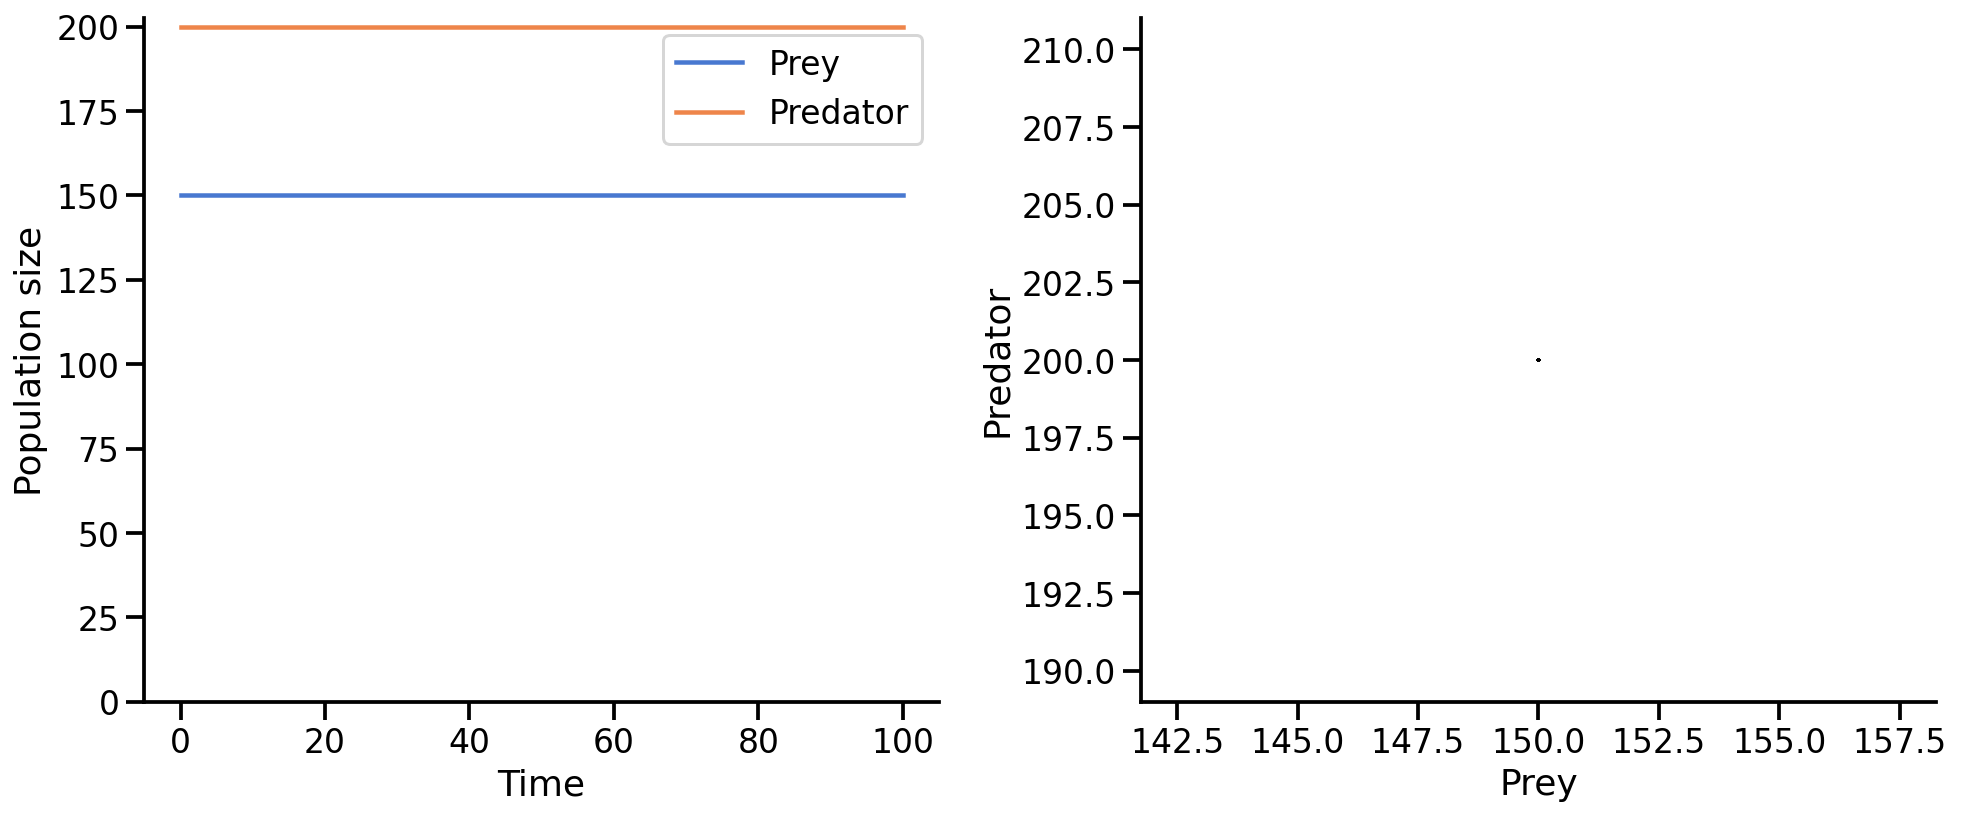

In [132]:
t, xy = solve_plot(x0=xstar, y0=ystar, tmax=100, b=b, h=h, ϵ=ϵ, d=d)
assert np.allclose(xy[0,:], xystar[0])
assert np.allclose(xy[1,:], xystar[1])

# Local stability

Stability is another important concept in dynamic modelling. 
We want to know if an equilibrium is locally stable: that is, if we perturbe the system (e.g. nudge it a bit)\, will the system return to the equilibrium?

![stability](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fcdn-images-1.medium.com%2Fmax%2F1600%2F0*df4enmd42HaD5Hdl.jpg&f=1&nofb=1)

We concentrate on small perturbations, that is, the concept of **local stability** (see [notebook on stability analysis](stability.ipynb) or ch. 8 in Otto and Day 2007).

Let's perturbe the equilibrium and check what the values of the ODE are.

In [133]:
xypert = xstar * 1.01, ystar * 1.01
print(xypert)
print(dxydt(0, xypert, b=b, h=h, ϵ=ϵ, d=d))

(151.5, 202.0)
[-1.515  1.212]


So after this perturbation, the prey population will decrease in size $\frac{dx}{dt}<0$ and the predator population will increase $\frac{dy}{dt}>0$.

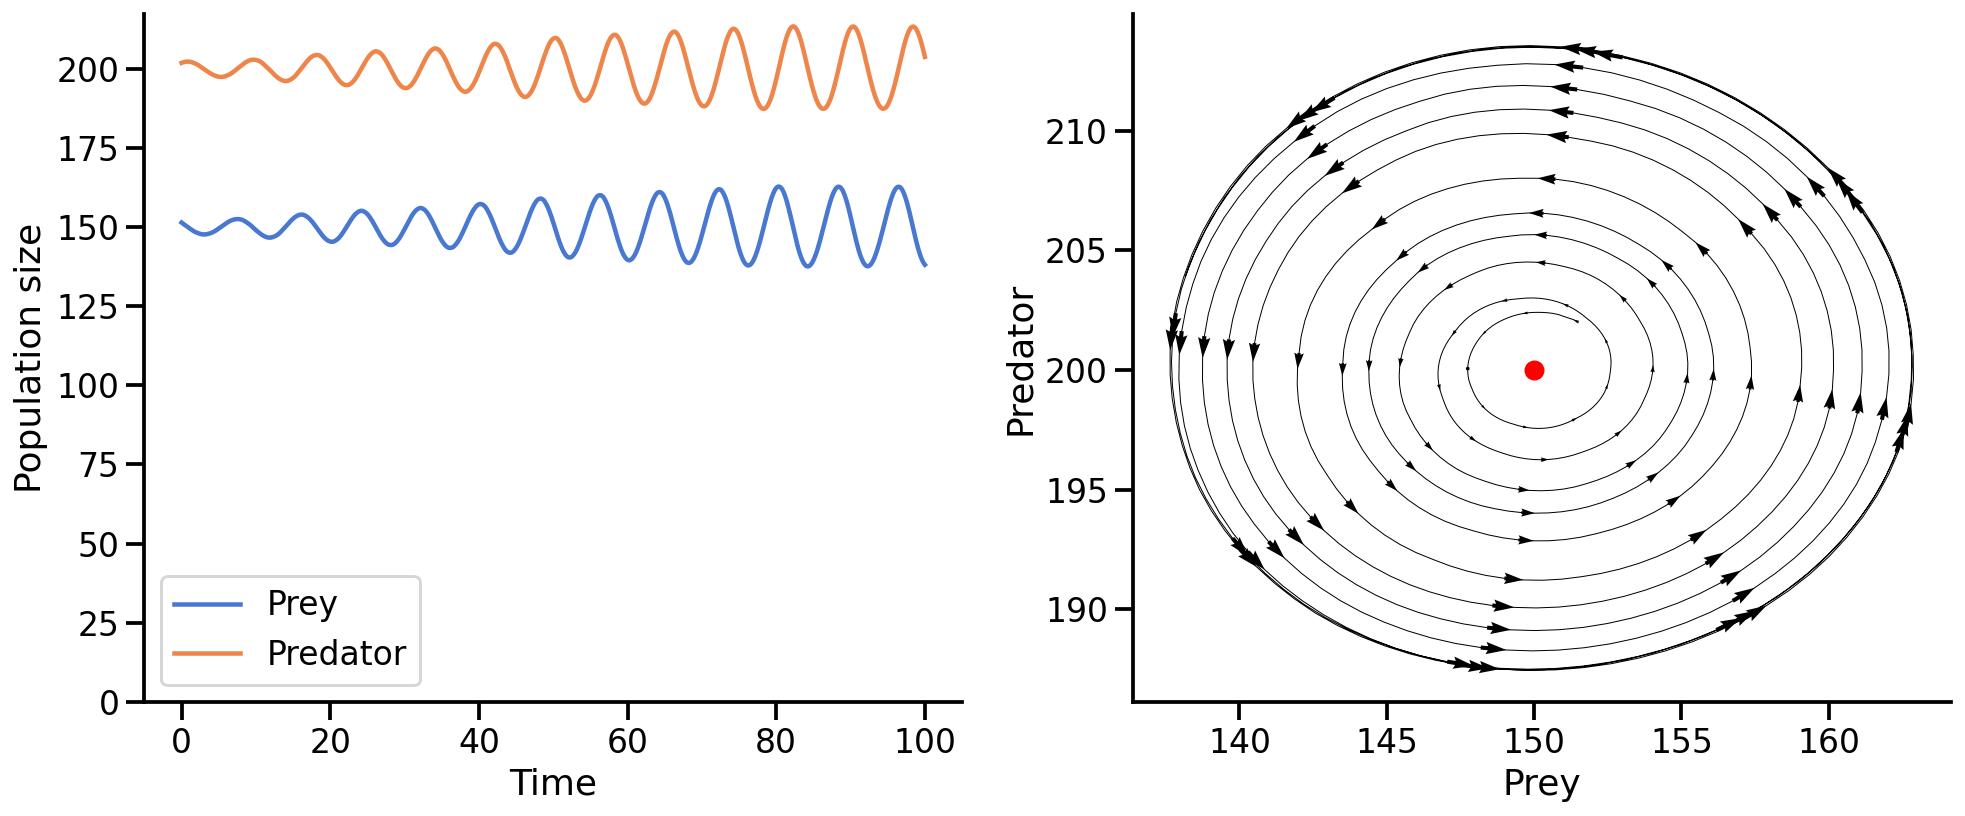

In [134]:
t, xy = solve_plot(*xypert, tmax=100, b=b, h=h, ϵ=ϵ, d=d)
plt.plot(*xystar, 'or');

So we see that the initial equilibirum point (right: time zero; left: red circle) is **unstable**: it "swirls" outwards, but is seems to "swirl" towards some limit cycle; it seems to converge to an orbit.

Let's continue the dynamics from where we stopped it. 

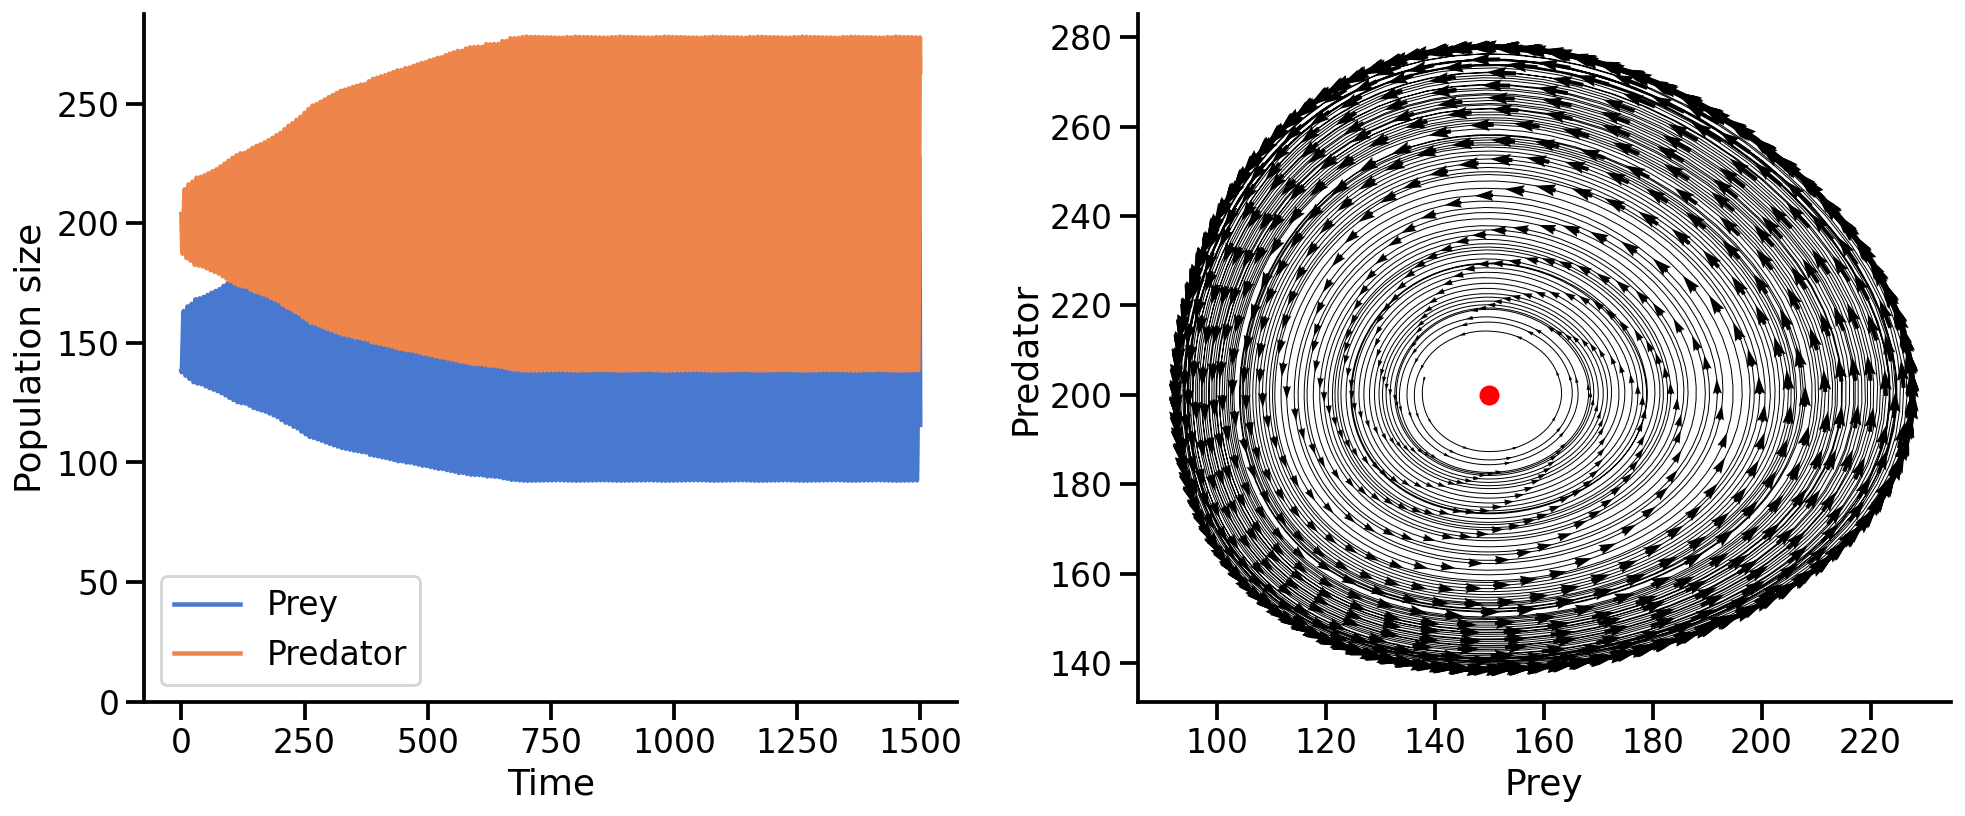

In [135]:
solve_plot(*xy[:, -1], tmax=1500, b=b, h=h, ϵ=ϵ, d=d)
plt.plot(*xystar, 'or');

## Stability analysis

We can generalize this observation of a non-stable equilibrium with local stability analysis, by finding the linearization of the non-linear model near the equilibrium, and then analyzing this linear system.

This linearization is given by the the Jacobian at the equiblirum $(x^*, y^*)$.

**The equilibrium is stable if all eigenvalues of the linear system have negative real parts.** (see [notebook on stability analysis](stability.ipynb) or ch. 8 in Otto and Day 2007).

For more details see references at the bottom of the page.

In [136]:
J = jac(0, xystar, b, h, ϵ, d) # the first argument is time, which doesn't matter in this system
print(J)

[[ 0.   -0.75]
 [ 0.8   0.  ]]


We can find the eigenvalues using SciPy:

In [137]:
eigs = scipy.linalg.eigvals(J)
print('eigenvalues:', eigs.real)
print('real parts are negative:', eigs.real < 0)

eigenvalues: [0. 0.]
real parts are negative: [False False]


The real parts of the eigenvalues are zero, so the equilibrium is unstable.

Is this the case for any parameter combination?

In [138]:
def is_stable(b, h, ϵ, d):
    xystar =  d/(ϵ*h), b/h
    J = jac(0, xystar, b, h, ϵ, d)
    eigs = scipy.linalg.eigvals(J)
    ρ = eigs.real.max() 
    return ρ < 0 and not np.isclose(ρ, 0)

In [140]:
b_ = 2/3
h_ = 4/3

ϵs = np.linspace(1e-6, 1, 51)
ds = np.linspace(0, 1, 50)

ρs = [is_stable(b_, h_, ϵ, d) for ϵ in ϵs for d in ds]
ρs = np.array(ρs).reshape(51, 50)

In [141]:
print('Unstable across range?', not ρs.any())

Unstable across range? True


## SymPy

Can we find an analytic solution for the stability question?

Let's use SymPy, a Python package for symbolic mathematics.

In [142]:
import sympy
sympy.init_printing()

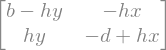

In [143]:
x, y, b_, h_, ϵ_, d_ = sympy.symbols('x y b h ϵ d')
dxdt = b_ * x - h_ * x * y
dydt = ϵ_ * h_ * x * y - d_ * y
J = sympy.Matrix([
    [sympy.diff(dxdt, x), sympy.diff(dxdt, y)],
    [sympy.diff(dydt, x), sympy.diff(dydt, y)]
])
J

First, the case of the trivial equilibrium $x=0, y=0$:

In [144]:
J.subs({x: 0, y: 0}).eigenvals()

The first eigenvalue is equal to $b>0$, so extinctions are not stable to perturbations.
This makes sense: if you add some prey, they will flourish in the absence of a predator.

Second, the more interesting case, the Jacobian at the equilibrium.

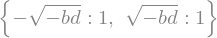

In [145]:
eigs = J.subs({x: d_/(ϵ_*h_), y: b_/h_}).eigenvals()
eigs

Since $b>0$ and $d>0$, then $bd>0$ and both eigenvalues are complex with a zero real part, so the equilibrium is "neutral".

In a [two-equation system](https://en.wikipedia.org/wiki/Linear_dynamical_system#Classification_in_two_dimensions) we can learn more about the stability from the product and sum of the eigenvalues by looking at the product and sum of the eigenvalues, $\Delta=\lambda_1 \lambda_2 = -bd < 0$ and $\tau=\lambda_1 + \lambda_2=0$.

So the equilibrium point is a _center_ of a stable cycle: there is a stable "orbit" around the fixed point, which was what we kindof suspected.

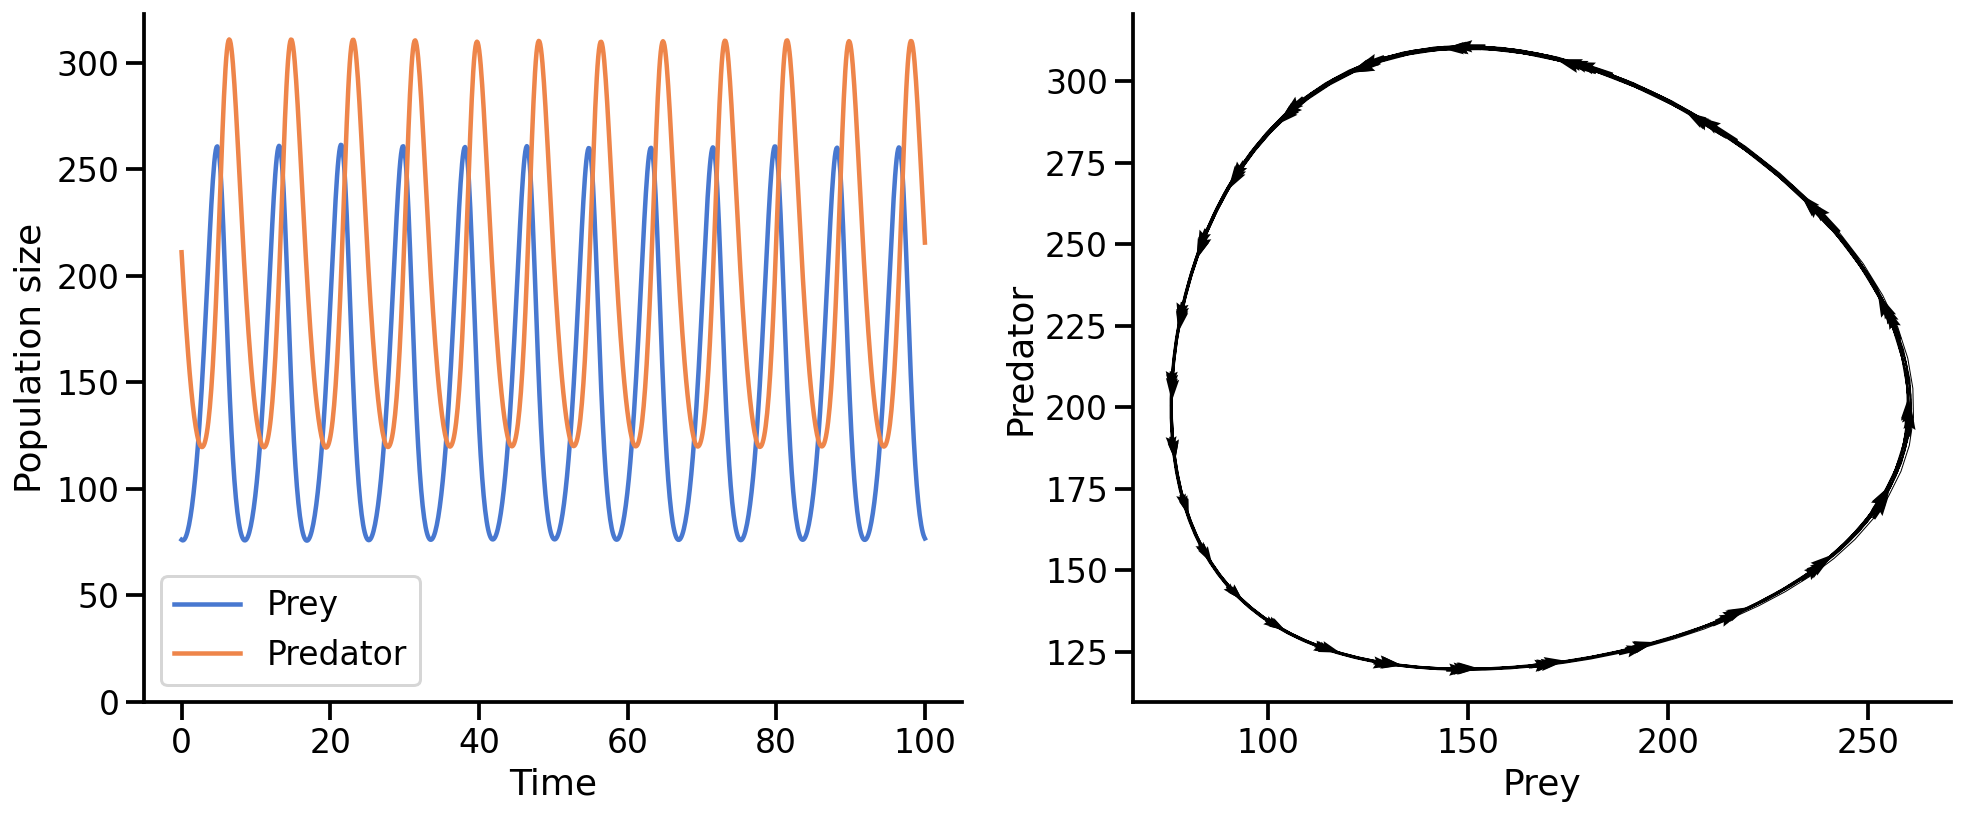

In [152]:
t, xy = solve_plot(76, 211, tmax=100, b=b, h=h, ε=ε, d=d);

# Stochastic effects 

The problem is that both prey and predator come very close to zero many times,  and therefore their populations will be subject to random extinctions, which cannot be reflected in a deterministic model.
This is sometimes called the "atto-fox problem", an atto-fox being a notional $10^{−18}$ of a fox.

If the prey goes extinct, so will the predator:

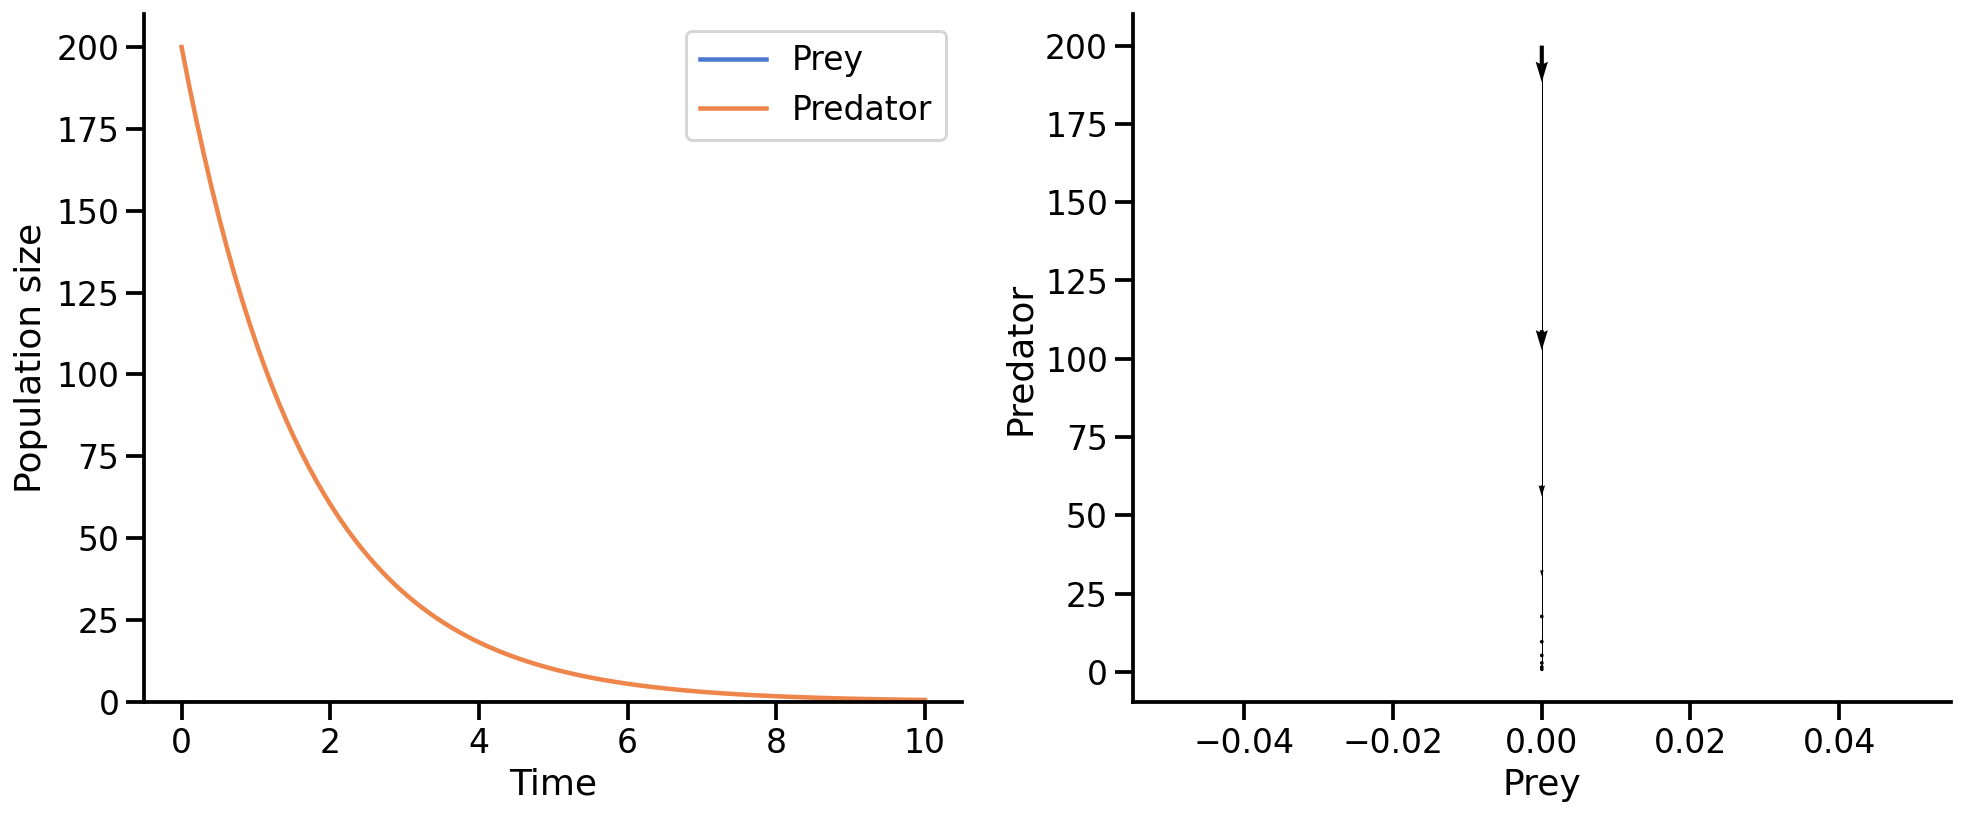

In [155]:
solve_plot(0, ystar, 10, b, h, ε, d);

and if the predator goes extinct, the prey population explodes:

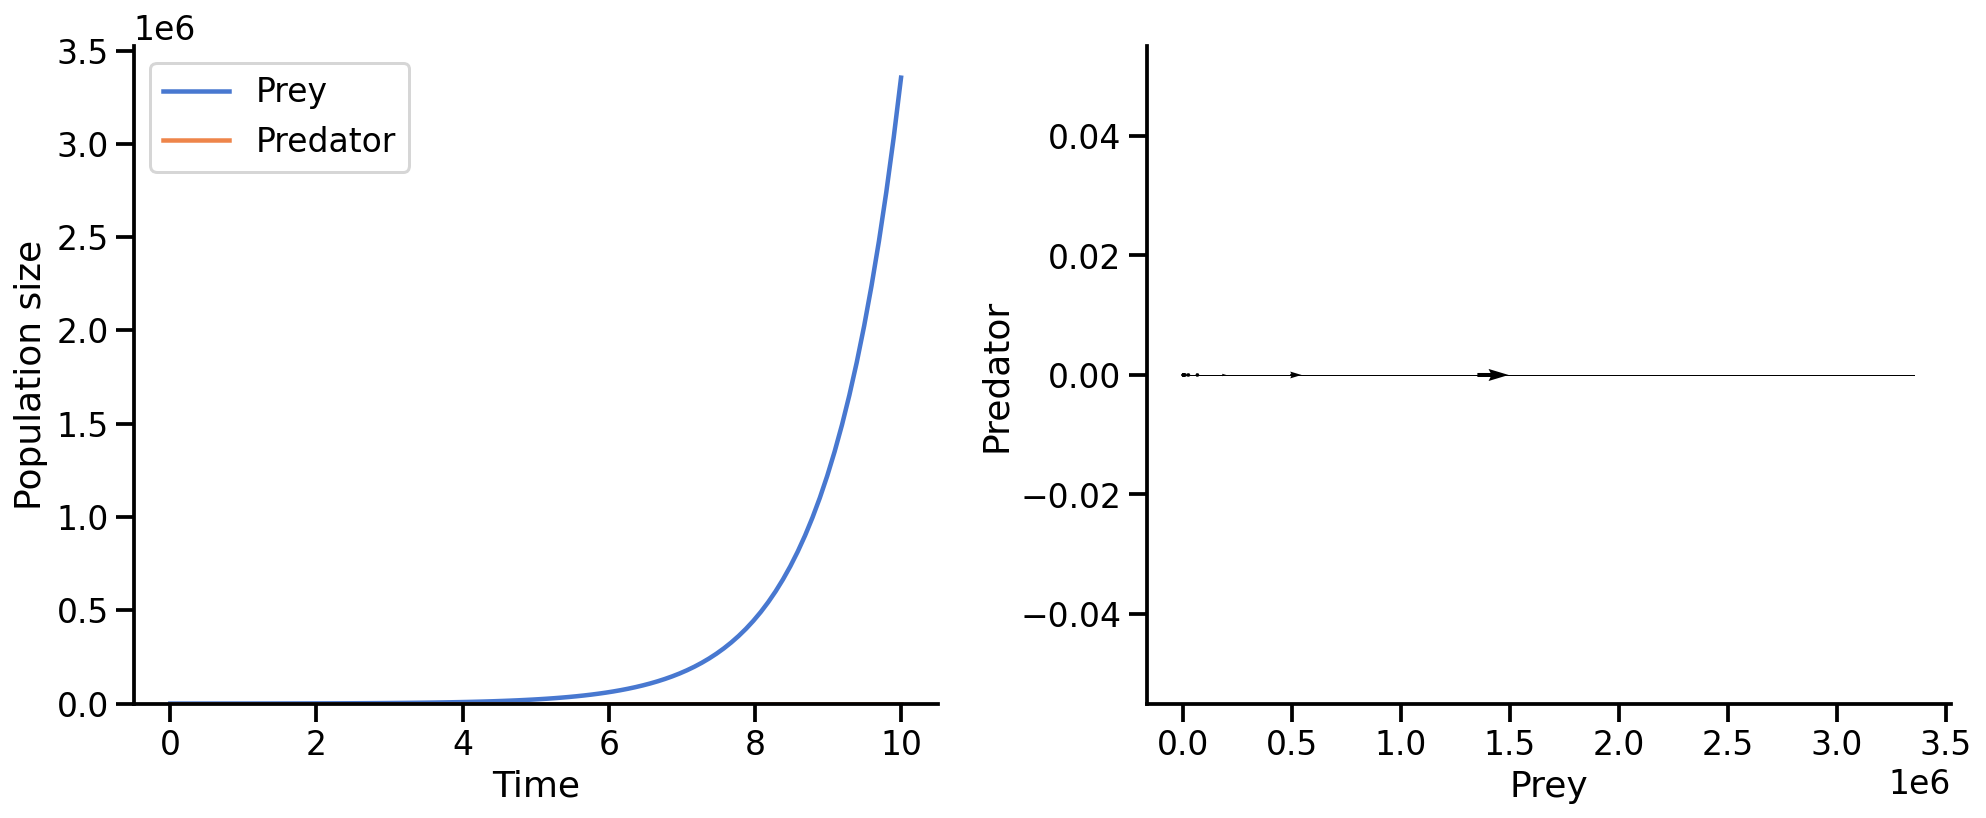

In [156]:
solve_plot(xstar, 0, 10, b, h, ε, d);

So clearly the model is not biologically reasonable - but it can still give us insight on species interactions.

Furthermore, we will come back to this problem and use a stochastic model.

# Further reading

- [Discussion of predation with some biological data](https://globalchange.umich.edu/globalchange1/current/lectures/predation/predation.html)
- [Isle Royale - Wolf and Moose](http://www.isleroyalewolf.org/http%3A//www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/nao.shtml)
- [Evolution towards oscillation or stability in a predator–prey system](http://rspb.royalsocietypublishing.org/content/277/1697/3163)
- A Biologist's Guide to Mathematical Modeling in Ecology and Evolution by Otto and Day 2007 (available online via the [library](https://idc-primo.hosted.exlibrisgroup.com/primo-explore/fulldisplay?docid=972IDC_INST_ALMA2152572240003105&context=L&vid=972IDC_INST_V1&search_scope=IDC)): 
 - Chapter 5 for equilibria and stability with one variable.
 - Chapter 7 for equilibria and stability with multiple variables.
 - Chapter 8 for equilibria and stability with multiple variables in non-linear models.

# Colophon
This notebook was written by [Yoav Ram](http://www.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.